In [69]:
import sys
import subprocess
    # !{sys.executable} -m pip install torchsummary
!{sys.executable} -m pip install torch-lr-finder
!{sys.executable} -m pip install torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
!{sys.executable} -m pip install grad-cam
!{sys.executable} -m pip install torchmetrics

#### Git clone Repo

In [85]:
local = True

# Define the repository details
repo_name = "ERA_v2"
git_repo_url = "https://github.com/Gishnumohan/ERA_v2.git"
branch_name = "main"
folder_name = "Assignment10"

if(local):
    #from utils import *
    %run utils.py         #to run every update in utils.py till code complition
    %run model.py
    %run trainer.py
    %run dataloader.py
else:
    # Clone the repository and checkout the specified branch
    subprocess.run(f"rm -rf {repo_name}", shell=True)
    subprocess.run(f"git clone {git_repo_url}", shell=True)
    subprocess.run(f"cd {repo_name} && git checkout {branch_name} && cd {folder_name}", shell=True)
    sys.path.append(f"/content/{repo_name}/{folder_name}")          # Add the cloned repository to Python path


<Figure size 640x480 with 0 Axes>

#### Import necessary modules

In [86]:
# Import necessary modules (external libs)
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder
import torch.nn as nn
import torchvision
from torchsummary import summary
import albumentations as A
import torch.utils.data as data


#Import model
from model import ResNet18 as Net


Set Global Value

In [87]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data?
data_path = "../../data"

# Specify the number of epochs
NUM_EPOCHS = 20
# Set the batch size
BATCH_SIZE = 512


# Set seed value for reproducibility
SEED = 26


Function to set Device as CUDA

In [88]:
mountDrive()
set_manualSeed(SEED)
device = setDevice()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using CUDA!


GET DATA

In [89]:
train_data = getCIFAR10dataset(root="../../data", train_flag=True, download_flag=True)

test_data =getCIFAR10dataset(root="../../data", train_flag=True, download_flag=True)

Files already downloaded and verified
Files already downloaded and verified


In [90]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# cutout needs to be half of the image size
cutout_size = 16

# Train Phase Transformations
train_transforms = A.Compose(
    A.Compose([
        A.PadIfNeeded(4), #border_mode=0 needs fill value
        A.RandomCrop(height=32, width=32, p=1.0),
        A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
        A.CoarseDropout( max_holes=1, max_height=cutout_size, max_width=cutout_size,
                        min_holes=1, min_height=cutout_size, min_width=cutout_size,
                        fill_value=[0.4915, 0.4823, 0.4468], mask_fill_value=None),
        A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
        ToTensorV2(),
    ])
)

# Test Phase Transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616]),
    ToTensorV2(),
])

Training DATASET and DATALOADER

In [91]:
train_ds = CIFAR10_dataset(data=train_data.data, targets=train_data.targets, transforms=train_transforms)
test_ds = CIFAR10_dataset(data=test_data.data, targets=test_data.targets, transforms=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if isCudaAvailabilty() else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)

View sample images from training dataset

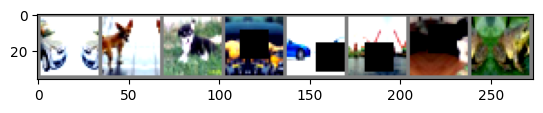

car   dog   dog   truck car   ship  dog   frog 


In [92]:
# get some random training images
sample_data = iter(train_loader)
images, labels = next(sample_data)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
show_samples(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [93]:
model = ResNet18().to(device)
modelSummary(model,(3,32,32), device)

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
ResNet                                   [1, 3, 32, 32]   --               [1, 10]          --               True
├─Conv2d: 1-1                            [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
├─Sequential: 1-3                        [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]  [3, 3]           [1, 64, 32, 32]  36,864           True
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]  [3, 3]           [1, 64, 

Find Learning Rate

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-04


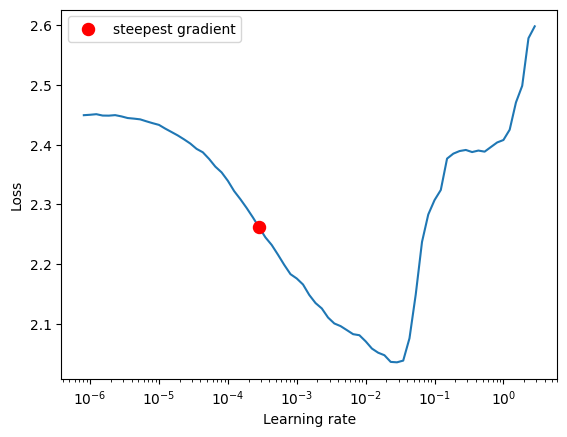

In [94]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

 lower lr = 1e-4 and upper lr = 1e-3 for once cycle scheduling

In [95]:
criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader), pct_start=0.2, div_factor=10)

Train and Test Model

In [96]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 20


Epoch 1


Train: Loss=1.3834, Batch_id=97, Accuracy=39.32: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0027,  Accuracy: 24744/50000  (49.49%)


Epoch 2


Train: Loss=1.2344, Batch_id=97, Accuracy=51.53: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0022,  Accuracy: 30170/50000  (60.34%)


Epoch 3


Train: Loss=1.1093, Batch_id=97, Accuracy=57.42: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0019,  Accuracy: 32682/50000  (65.36%)


Epoch 4


Train: Loss=1.0806, Batch_id=97, Accuracy=61.09: 100%|██████████| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0018,  Accuracy: 33139/50000  (66.28%)


Epoch 5


Train: Loss=1.0390, Batch_id=97, Accuracy=64.41: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0018,  Accuracy: 33942/50000  (67.88%)


Epoch 6


Train: Loss=0.8881, Batch_id=97, Accuracy=66.96: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0016,  Accuracy: 35415/50000  (70.83%)


Epoch 7


Train: Loss=0.8686, Batch_id=97, Accuracy=68.66: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0013,  Accuracy: 37708/50000  (75.42%)


Epoch 8


Train: Loss=0.7723, Batch_id=97, Accuracy=70.68: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0015,  Accuracy: 36635/50000  (73.27%)


Epoch 9


Train: Loss=0.7236, Batch_id=97, Accuracy=72.74: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0013,  Accuracy: 37887/50000  (75.77%)


Epoch 10


Train: Loss=0.7273, Batch_id=97, Accuracy=73.99: 100%|██████████| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0013,  Accuracy: 38160/50000  (76.32%)


Epoch 11


Train: Loss=0.7872, Batch_id=97, Accuracy=75.17: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0011,  Accuracy: 40398/50000  (80.80%)


Epoch 12


Train: Loss=0.6185, Batch_id=97, Accuracy=76.49: 100%|██████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0010,  Accuracy: 41312/50000  (82.62%)


Epoch 13


Train: Loss=0.6152, Batch_id=97, Accuracy=77.52: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0010,  Accuracy: 41126/50000  (82.25%)


Epoch 14


Train: Loss=0.5402, Batch_id=97, Accuracy=78.92: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0008,  Accuracy: 42927/50000  (85.85%)


Epoch 15


Train: Loss=0.6551, Batch_id=97, Accuracy=79.45: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0008,  Accuracy: 42376/50000  (84.75%)


Epoch 16


Train: Loss=0.5716, Batch_id=97, Accuracy=80.40: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0009,  Accuracy: 42051/50000  (84.10%)


Epoch 17


Train: Loss=0.5246, Batch_id=97, Accuracy=81.06: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0008,  Accuracy: 42693/50000  (85.39%)


Epoch 18


Train: Loss=0.4946, Batch_id=97, Accuracy=82.20: 100%|██████████| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0007,  Accuracy: 43941/50000  (87.88%)


Epoch 19


Train: Loss=0.5276, Batch_id=97, Accuracy=82.39: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0007,  Accuracy: 44113/50000  (88.23%)


Epoch 20


Train: Loss=0.5591, Batch_id=97, Accuracy=82.97: 100%|██████████| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0006,  Accuracy: 44912/50000  (89.82%)




Misclassifed image

In [97]:
misclassified = {}
get_misclassified(model, device, test_loader, misclassified, num_samples=10)
show_misclassified_imgs(misclassified, classes, nmax=10)


NameError: name 'get_CIFAR10_musigma' is not defined

In [ ]:
input_tensor = misclassified['data']
original_imgs = get_denormalized_imgs(input_tensor)
wrong_preds = misclassified['pred']
correct_labels = misclassified['target']
target_layers = [model.layer3[-1]]
grayscale_cams, cam_image = get_gradcam_img(model, target_layers, input_tensor, original_imgs, wrong_preds)
show_gradcam_plots(grayscale_cams, cam_image, original_imgs, classes, \
                       wrong_preds, correct_labels, resize=(1024,1024), figsize=(20,20))